In [ ]:
pip install tqdm

Generating embeddings: 100%|██████████| 90/90 [03:17<00:00,  2.20s/embedding]


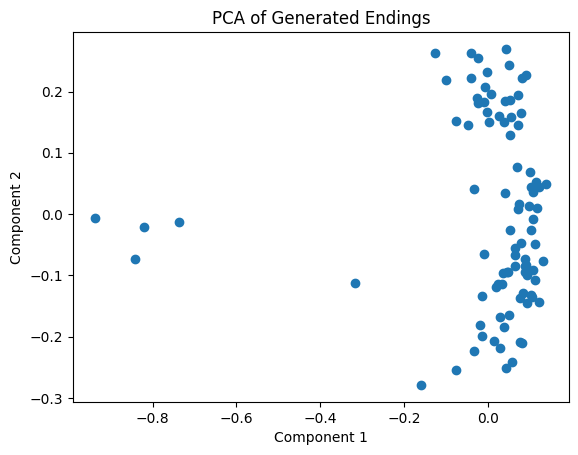

In [7]:
import requests
import csv
from tqdm import tqdm  # Progress bar library
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# API URL
api_url = "http://localhost:11434/api/generate"
embed_url = "http://localhost:11434/api/embed"

# List of models to use
models = ['llama3.1:8b','llama3.2:1b', 'llama3.2:3b']
movies = ['Fellowship of the Ring', 'The Two Towers', 'Return of the King']
scripts = ["https://imsdb.com/scripts/Lord-of-the-Rings-Fellowship-of-the-Ring,-The.html",
           "https://imsdb.com/scripts/Lord-of-the-Rings-The-Two-Towers.html",
           "https://imsdb.com/scripts/Lord-of-the-Rings-Return-of-the-King.html"]

# Function to generate alternative endings and save to CSV
def generate_and_save_results(models, movies):
    total_tasks = len(models) * len(movies) * 10  # Total number of tasks (models * movies * prompts)
    
    with open('lotr_endings.csv', 'w', newline='', encoding='utf-8') as csvfile:  # Set encoding to 'utf-8'
        writer = csv.writer(csvfile)
        writer.writerow(['Model', 'Movie', 'Prompt Number', 'Generated Ending'])

        # Progress bar for the overall generation process
        with tqdm(total=total_tasks, desc="Generating endings", unit="task") as pbar:
            for model in models:
                for movie, script in zip(movies, scripts):
                    for i in range(10):
                        prompt = f"Based on {script}, what could be an alternative ending for {movie}?"
                        payload = {
                            "model": model,
                            "prompt": prompt,
                            "stream": False
                        }
                        response = requests.post(api_url, json=payload).json()
                        generated_text = response['response']
                        
                        # Write the result to CSV
                        writer.writerow([model, movie, i+1, generated_text])
                        
                        # Update the progress bar
                        pbar.update(1)

# Function to generate embeddings for the generated text
def generate_embeddings(text):
    payload = {
        "model": "mxbai-embed-large",
        "input": text
    }
    response = requests.post(embed_url, json=payload).json()
    return response['embeddings'][0]

# Call the function to generate and save results
generate_and_save_results(models, movies)

# Read the CSV and generate embeddings
endings = []
with open('lotr_endings.csv', 'r', encoding='utf-8') as csvfile:  # Set encoding to 'utf-8'
    reader = csv.DictReader(csvfile)

    # Progress bar for generating embeddings
    with tqdm(total=len(list(reader)), desc="Generating embeddings", unit="embedding") as pbar:
        csvfile.seek(0)  # Move back to the beginning after counting rows
        next(reader)  # Skip header row
        for row in reader:
            embedding = generate_embeddings(row['Generated Ending'])
            endings.append(embedding)
            # Update the progress bar
            pbar.update(1)

# Perform PCA on the embeddings
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(endings)

# Visualize the PCA result
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
plt.title('PCA of Generated Endings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


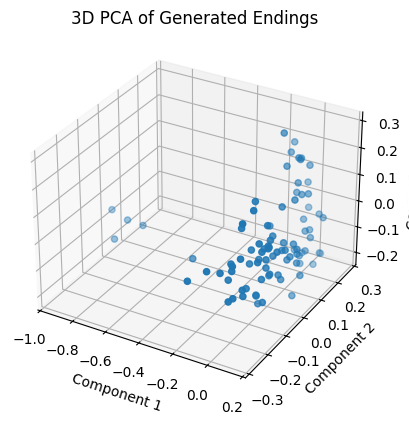

In [10]:
# Perform PCA on the embeddings (3D)
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(endings)

# 3D Visualization of PCA results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2])

# Set labels and title
ax.set_title('3D PCA of Generated Endings')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()

In [11]:
# Function to save the CSV with embeddings
def save_csv_with_embeddings(input_csv, output_csv, embeddings):
    with open(input_csv, 'r', encoding='utf-8') as infile, open(output_csv, 'w', newline='', encoding='utf-8') as outfile:
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames + ['Embedding']  # Add 'Embedding' column
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)

        # Write the header
        writer.writeheader()

        # Write rows along with their corresponding embeddings
        for row, embedding in zip(reader, embeddings):
            row['Embedding'] = embedding  # Add embedding as a new column
            writer.writerow(row)

# Call the function to save embeddings to a new CSV
output_csv = 'lotr_endings_with_embeddings.csv'
save_csv_with_embeddings('lotr_endings.csv', output_csv, endings)



Finding optimal clusters for Fellowship of the Ring:

Finding optimal clusters for The Two Towers:

Finding optimal clusters for Return of the King:


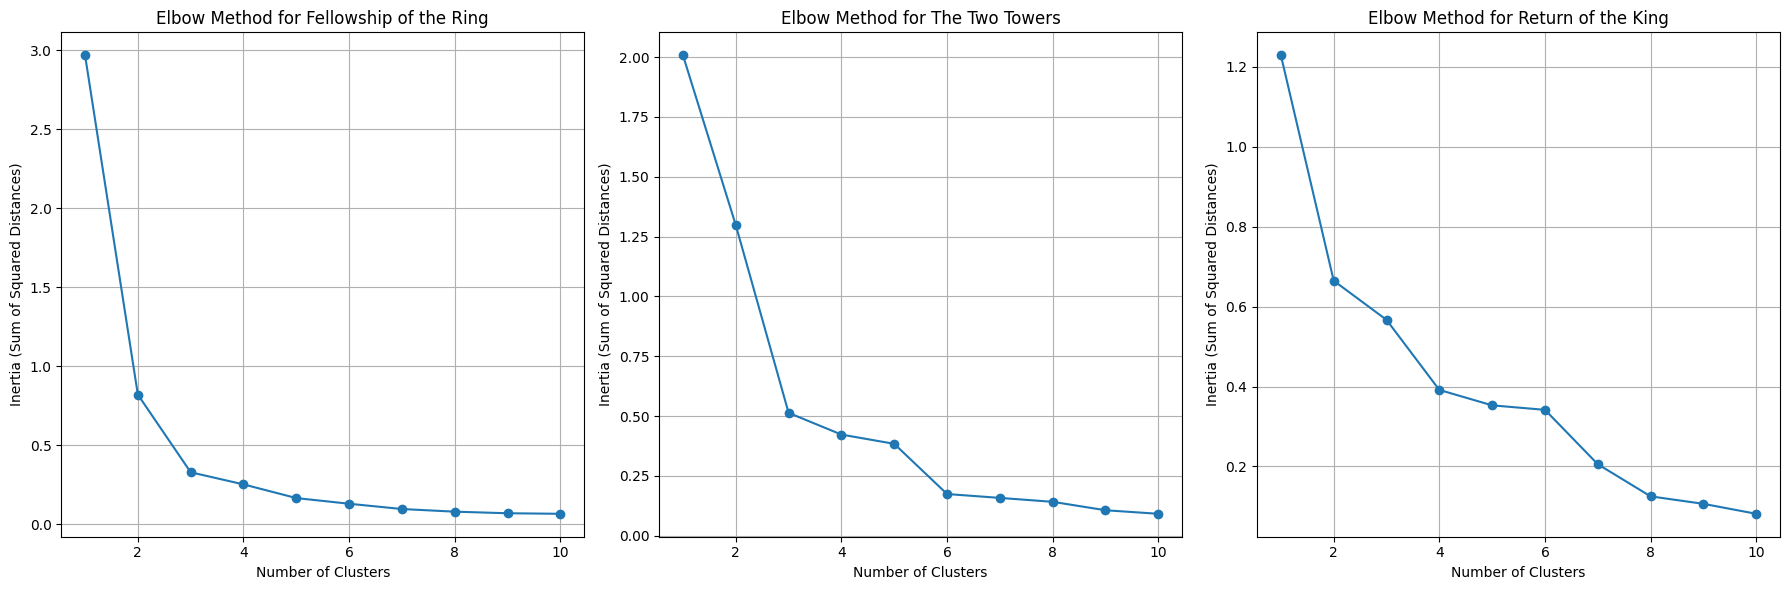

In [21]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Function to compute the optimal number of clusters using the Elbow Method for each movie
def find_optimal_clusters_per_movie(reduced_embeddings, labels, movies, max_clusters=10):
    # Create a 1-row, 3-column subplot grid
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Loop over each movie and compute elbow method
    for idx, movie in enumerate(movies):
        print(f"\nFinding optimal clusters for {movie}:")
        
        # Filter embeddings for the current movie
        movie_indices = np.where(labels == movie)
        movie_embeddings = reduced_embeddings[movie_indices]

        inertias = []

        # Calculate inertia for different numbers of clusters
        for k in range(1, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(movie_embeddings)
            inertias.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the nearest cluster center

        # Plot the inertia for each number of clusters in a subplot
        ax = axes[idx]
        ax.plot(range(1, max_clusters + 1), inertias, marker='o')
        ax.set_title(f'Elbow Method for {movie}')
        ax.set_xlabel('Number of Clusters')
        ax.set_ylabel('Inertia (Sum of Squared Distances)')
        ax.grid(True)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Function to separate embeddings by movie and find the optimal cluster number
def separate_and_find_optimal_clusters(reduced_embeddings, original_data):
    movie_labels = ['Fellowship of the Ring', 'The Two Towers', 'Return of the King']
    labels = np.array([row['Movie'] for row in original_data])

    # Call the function to find the optimal clusters per movie
    find_optimal_clusters_per_movie(reduced_embeddings, labels, movie_labels)

# Load original data (with generated endings)
original_data = []
with open('lotr_endings.csv', 'r', encoding='utf-8') as csvfile:  # Set encoding to 'utf-8'
    reader = csv.DictReader(csvfile)
    for row in reader:
        original_data.append(row)

# Call the function to separate data and find the best clusters for each movie
separate_and_find_optimal_clusters(reduced_embeddings, original_data)



Clustering and visualizing for Fellowship of the Ring:

Clustering and visualizing for The Two Towers:

Clustering and visualizing for Return of the King:


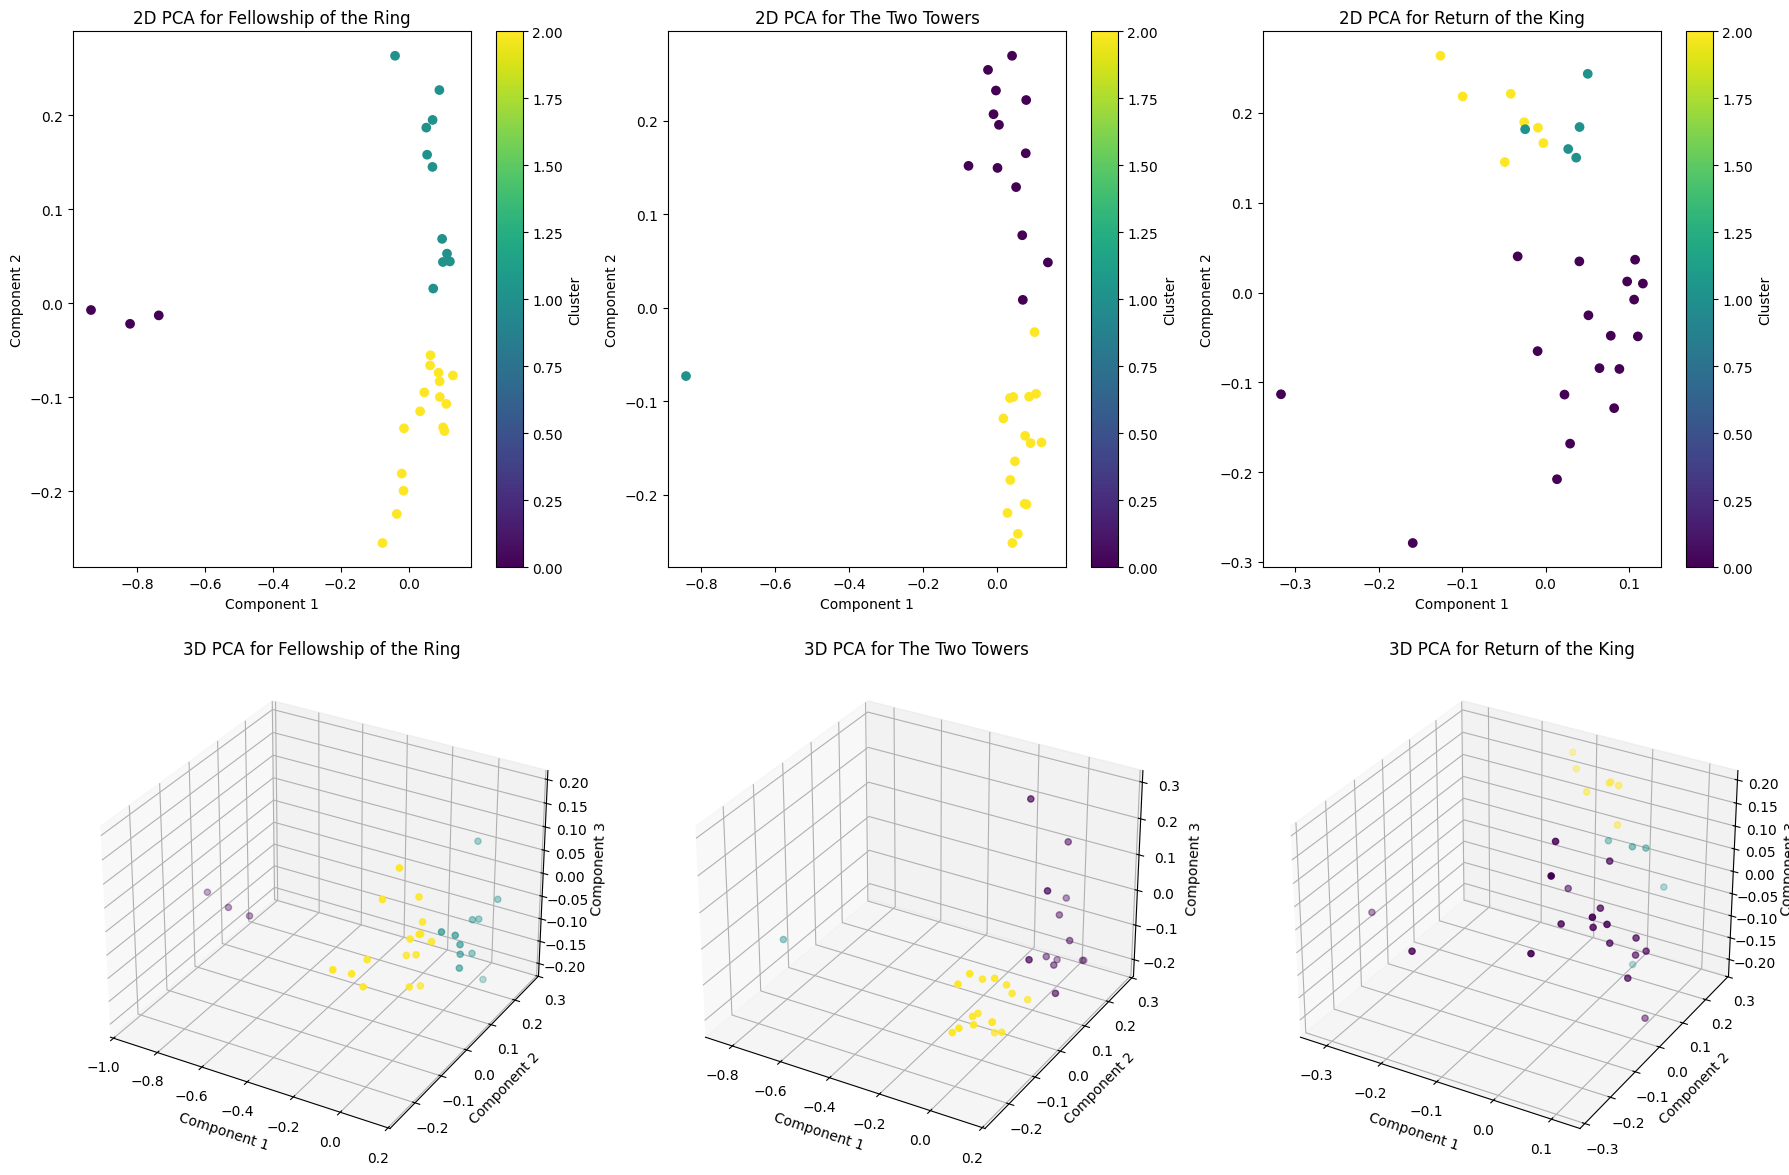

In [22]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Function to perform clustering and visualize in 2D and 3D for each movie
def cluster_and_visualize_per_movie(reduced_embeddings, original_data, num_clusters=3):
    movie_labels = ['Fellowship of the Ring', 'The Two Towers', 'Return of the King']
    labels = np.array([row['Movie'] for row in original_data])

    # Create a figure with a 2x3 grid (2 rows, 3 columns)
    fig = plt.figure(figsize=(18, 12))
    
    # Iterate over each movie and perform clustering
    for idx, movie in enumerate(movie_labels):
        print(f"\nClustering and visualizing for {movie}:")
        
        # Filter embeddings for the current movie
        movie_indices = np.where(labels == movie)
        movie_embeddings = reduced_embeddings[movie_indices]

        # Perform KMeans clustering with 3 clusters
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        movie_cluster_labels = kmeans.fit_predict(movie_embeddings)

        # 2D Visualization
        ax2d = fig.add_subplot(2, 3, idx + 1)  # Place in the first row
        scatter = ax2d.scatter(movie_embeddings[:, 0], movie_embeddings[:, 1], 
                               c=movie_cluster_labels, cmap='viridis', label=movie)
        ax2d.set_title(f'2D PCA for {movie}')
        ax2d.set_xlabel('Component 1')
        ax2d.set_ylabel('Component 2')
        fig.colorbar(scatter, ax=ax2d, label='Cluster')

        # 3D Visualization
        ax3d = fig.add_subplot(2, 3, idx + 4, projection='3d')  # Place in the second row
        ax3d.scatter(movie_embeddings[:, 0], movie_embeddings[:, 1], movie_embeddings[:, 2], 
                     c=movie_cluster_labels, cmap='viridis')
        ax3d.set_title(f'3D PCA for {movie}')
        ax3d.set_xlabel('Component 1')
        ax3d.set_ylabel('Component 2')
        ax3d.set_zlabel('Component 3')

    # Adjust the layout
    plt.tight_layout()
    plt.show()

# Load original data (with generated endings)
original_data = []
with open('lotr_endings.csv', 'r', encoding='utf-8') as csvfile:  # Set encoding to 'utf-8'
    reader = csv.DictReader(csvfile)
    for row in reader:
        original_data.append(row)

# Call the function to perform clustering and visualize results
cluster_and_visualize_per_movie(reduced_embeddings, original_data, num_clusters=3)


In [ ]:
pip install adjustText



Clustering and visualizing for Fellowship of the Ring:

Clustering and visualizing for The Two Towers:

Clustering and visualizing for Return of the King:


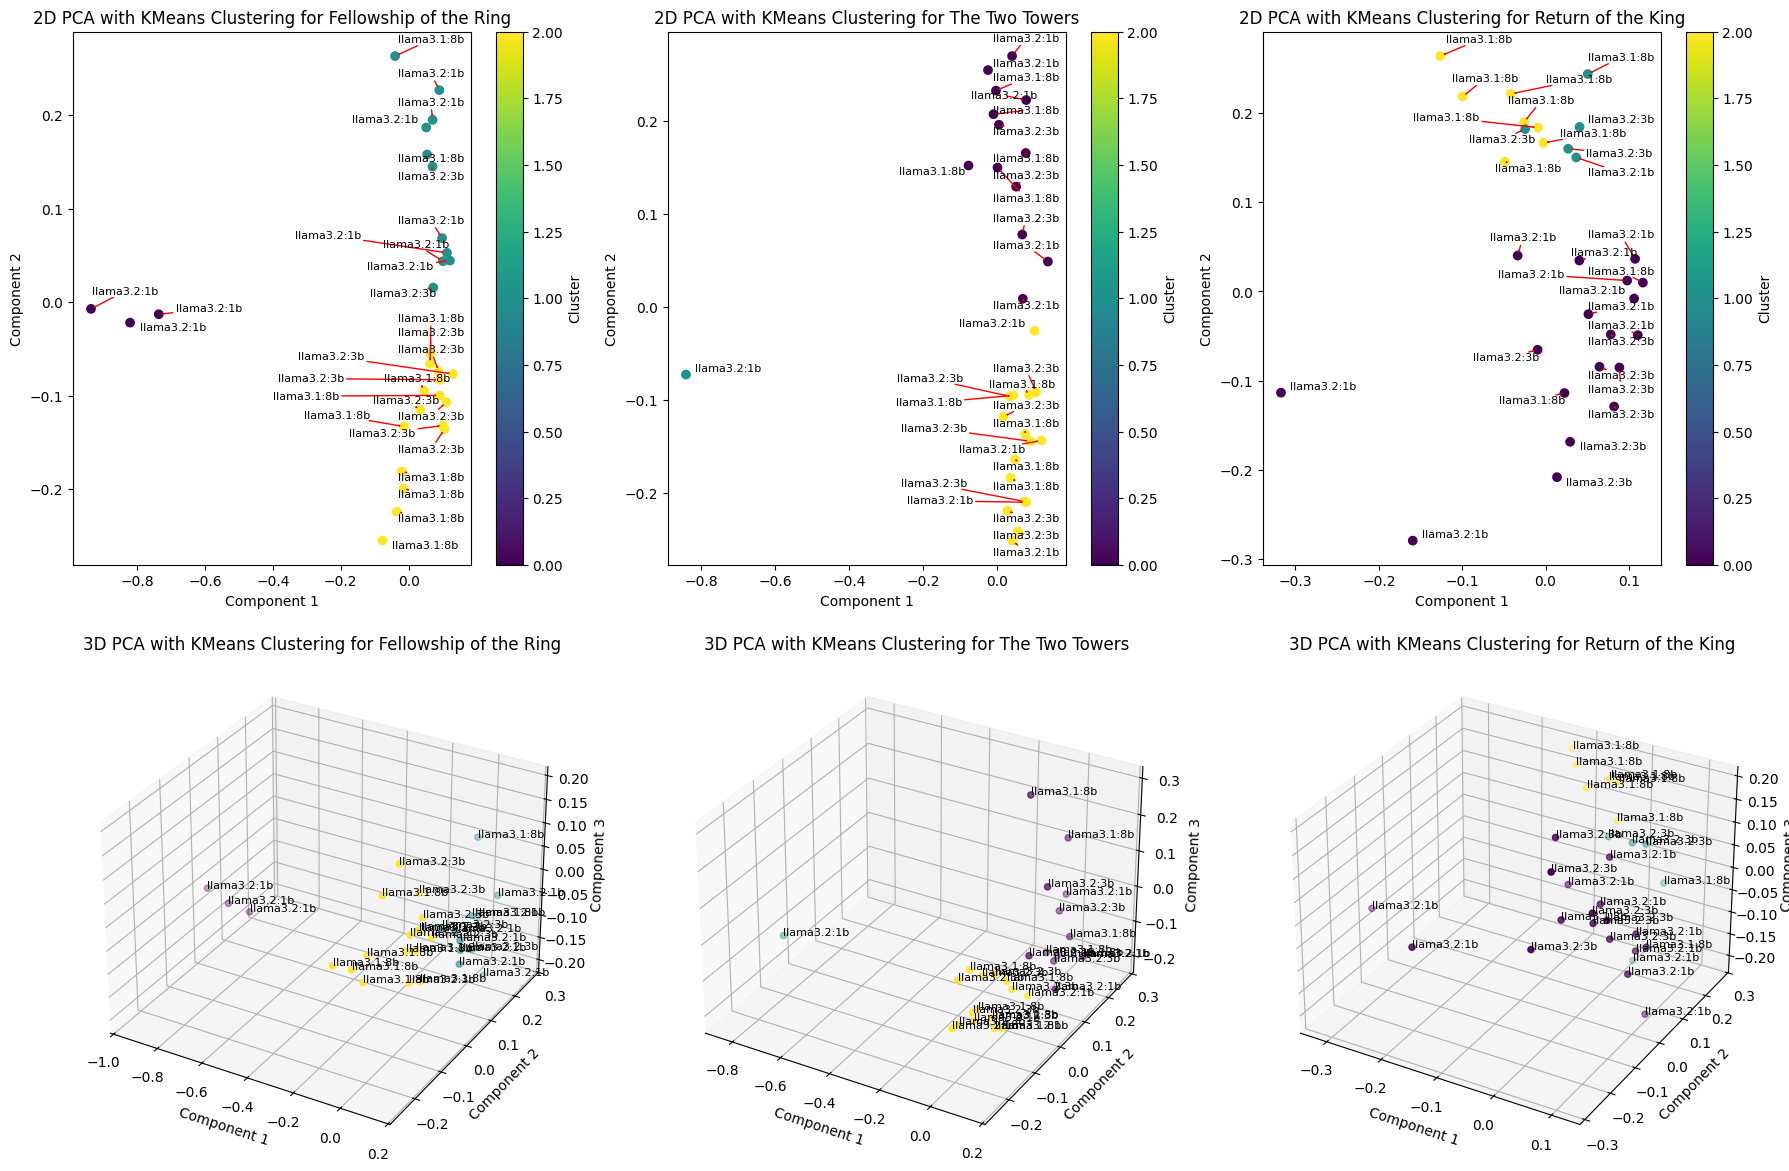

In [30]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from adjustText import adjust_text  # To avoid overlap in annotations

# Function to perform clustering and visualize in 2D and 3D for each movie, with model annotations
def cluster_and_visualize_per_movie_with_annotations(reduced_embeddings, original_data, num_clusters=3):
    movie_labels = ['Fellowship of the Ring', 'The Two Towers', 'Return of the King']
    labels = np.array([row['Movie'] for row in original_data])

    # Create a figure with a 2x3 grid (2 rows, 3 columns)
    fig = plt.figure(figsize=(18, 12))
    
    # Iterate over each movie and perform clustering
    for idx, movie in enumerate(movie_labels):
        print(f"\nClustering and visualizing for {movie}:")
        
        # Filter embeddings and original data for the current movie
        movie_indices = np.where(labels == movie)
        movie_embeddings = reduced_embeddings[movie_indices]
        movie_data = np.array(original_data)[movie_indices]

        # Perform KMeans clustering with 3 clusters
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        movie_cluster_labels = kmeans.fit_predict(movie_embeddings)

        # 2D Visualization with annotations
        ax2d = fig.add_subplot(2, 3, idx + 1)  # 2D plots on the first row
        scatter = ax2d.scatter(movie_embeddings[:, 0], movie_embeddings[:, 1], c=movie_cluster_labels, cmap='viridis', label=movie)
        ax2d.set_title(f'2D PCA with KMeans Clustering for {movie}')
        ax2d.set_xlabel('Component 1')
        ax2d.set_ylabel('Component 2')
        fig.colorbar(scatter, ax=ax2d, label='Cluster')

        # Annotate each point with the model name and adjust to prevent overlap
        texts = []
        for i, data in enumerate(movie_data):
            texts.append(ax2d.text(movie_embeddings[i, 0], movie_embeddings[i, 1], data['Model'], fontsize=8))
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

        # 3D Visualization with annotations
        ax3d = fig.add_subplot(2, 3, idx + 4, projection='3d')  # 3D plots on the second row
        scatter = ax3d.scatter(movie_embeddings[:, 0], movie_embeddings[:, 1], movie_embeddings[:, 2], c=movie_cluster_labels, cmap='viridis')
        ax3d.set_title(f'3D PCA with KMeans Clustering for {movie}')
        ax3d.set_xlabel('Component 1')
        ax3d.set_ylabel('Component 2')
        ax3d.set_zlabel('Component 3')

        # Annotate each point with the model name in 3D
        for i, data in enumerate(movie_data):
            ax3d.text(movie_embeddings[i, 0], movie_embeddings[i, 1], movie_embeddings[i, 2], data['Model'], fontsize=8)

    # Adjust the layout
    plt.tight_layout()
    plt.show()

# Load original data (with generated endings)
original_data = []
with open('lotr_endings.csv', 'r', encoding='utf-8') as csvfile:  # Set encoding to 'utf-8'
    reader = csv.DictReader(csvfile)
    for row in reader:
        original_data.append(row)

# Call the function to perform clustering and visualize results with model annotations
cluster_and_visualize_per_movie_with_annotations(reduced_embeddings, original_data, num_clusters=3)


In [31]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

# Function to perform clustering and analyze for same model in different clusters, and same cluster but different movie groups
def analyze_clusters_per_movie_with_annotations_separate(reduced_embeddings, original_data, num_clusters=3):
    movie_labels = ['Fellowship of the Ring', 'The Two Towers', 'Return of the King']
    labels = np.array([row['Movie'] for row in original_data])

    # Iterate over each movie and perform clustering
    for movie in movie_labels:
        print(f"\nAnalyzing clusters for {movie}:")

        # Filter embeddings and original data for the current movie
        movie_indices = np.where(labels == movie)
        movie_embeddings = reduced_embeddings[movie_indices]
        movie_data = np.array(original_data)[movie_indices]

        # Perform KMeans clustering with 3 clusters
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        movie_cluster_labels = kmeans.fit_predict(movie_embeddings)

        # Store the model, movie, and cluster information for further analysis
        results = []
        for i, data in enumerate(movie_data):
            results.append({
                'Model': data['Model'],
                'Movie': movie,
                'Cluster': movie_cluster_labels[i]
            })

        # Convert results into a DataFrame for analysis
        df = pd.DataFrame(results)

        # 1. Same Model, Different Cluster for this movie
        same_model_diff_cluster = df.groupby('Model')['Cluster'].nunique()
        same_model_diff_cluster = same_model_diff_cluster[same_model_diff_cluster > 1].index.tolist()
        df_same_model_diff_cluster = df[df['Model'].isin(same_model_diff_cluster)]

        print(f"\nFull Table of Same Model Different Cluster for {movie}:")
        print(df_same_model_diff_cluster)

        # 2. Same Cluster, Different Movie Group for this movie
        same_cluster_diff_group = df.groupby('Cluster')['Movie'].nunique()
        same_cluster_diff_group = same_cluster_diff_group[same_cluster_diff_group > 1].index.tolist()
        df_same_cluster_diff_group = df[df['Cluster'].isin(same_cluster_diff_group)]

        print(f"\nFull Table of Same Cluster Different Group for {movie}:")
        print(df_same_cluster_diff_group)

        # 3. Count clusters with different models for this movie
        cluster_model_counts = pd.crosstab(df['Cluster'], df['Model'])

        print(f"\nCluster vs. Model Count Table for {movie}:")
        print(cluster_model_counts)

# Load original data (with generated endings)
original_data = []
with open('lotr_endings.csv', 'r', encoding='utf-8') as csvfile:  # Set encoding to 'utf-8'
    reader = csv.DictReader(csvfile)
    for row in reader:
        original_data.append(row)

# Call the function to perform clustering and show full tables per movie
analyze_clusters_per_movie_with_annotations_separate(reduced_embeddings, original_data, num_clusters=3)



Analyzing clusters for Fellowship of the Ring:

Full Table of Same Model Different Cluster for Fellowship of the Ring:
          Model                   Movie  Cluster
0   llama3.1:8b  Fellowship of the Ring        1
1   llama3.1:8b  Fellowship of the Ring        2
2   llama3.1:8b  Fellowship of the Ring        2
3   llama3.1:8b  Fellowship of the Ring        2
4   llama3.1:8b  Fellowship of the Ring        2
5   llama3.1:8b  Fellowship of the Ring        2
6   llama3.1:8b  Fellowship of the Ring        2
7   llama3.1:8b  Fellowship of the Ring        1
8   llama3.1:8b  Fellowship of the Ring        2
9   llama3.1:8b  Fellowship of the Ring        2
10  llama3.2:1b  Fellowship of the Ring        1
11  llama3.2:1b  Fellowship of the Ring        0
12  llama3.2:1b  Fellowship of the Ring        1
13  llama3.2:1b  Fellowship of the Ring        0
14  llama3.2:1b  Fellowship of the Ring        1
15  llama3.2:1b  Fellowship of the Ring        1
16  llama3.2:1b  Fellowship of the Ring        

In [47]:
import pandas as pd 
from sklearn.cluster import KMeans
import numpy as np
import csv
from itertools import combinations

# Function to find and show one pair of same model but different cluster and same cluster but different model
def find_and_show_pairs(reduced_embeddings, original_data, num_clusters=3):
    movie_labels = ['Fellowship of the Ring', 'The Two Towers', 'Return of the King']
    labels = np.array([row['Movie'] for row in original_data])

    # Iterate over each movie and perform clustering
    for movie in movie_labels:
        print(f"\nAnalyzing clusters for {movie}:")

        # Filter embeddings and original data for the current movie
        movie_indices = np.where(labels == movie)
        movie_embeddings = reduced_embeddings[movie_indices]
        movie_data = np.array(original_data)[movie_indices]

        # Perform KMeans clustering with specified number of clusters
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        movie_cluster_labels = kmeans.fit_predict(movie_embeddings)

        # Store the model, movie, cluster, and generated ending information for further analysis
        results = []
        for i, data in enumerate(movie_data):
            results.append({
                'Model': data['Model'],
                'Movie': movie,
                'Cluster': movie_cluster_labels[i],
                'Generated Ending': data['Generated Ending']
            })

        # Convert results into a DataFrame for analysis
        df = pd.DataFrame(results)

        # 1. Find one pair for Same Model but Different Cluster
        df_grouped_model = df.groupby('Model').apply(lambda x: list(combinations(x.index, 2))).reset_index(drop=True)
        df_grouped_model = df_grouped_model.explode().dropna()
        df_grouped_model = pd.DataFrame(df_grouped_model.tolist(), columns=['Pair_1', 'Pair_2'])
        df_grouped_model['Cluster_1'] = df_grouped_model['Pair_1'].apply(lambda x: df.loc[x, 'Cluster'])
        df_grouped_model['Cluster_2'] = df_grouped_model['Pair_2'].apply(lambda x: df.loc[x, 'Cluster'])
        df_same_model_diff_cluster = df_grouped_model[df_grouped_model['Cluster_1'] != df_grouped_model['Cluster_2']]

        print(f"\nSame Model but Different Cluster for {movie}:")
        if not df_same_model_diff_cluster.empty:
            pair = df_same_model_diff_cluster.iloc[0]
            pair_1, pair_2 = pair['Pair_1'], pair['Pair_2']
            print(f"Movie: {movie}, Model: {df.loc[pair_1, 'Model']}")
            print(f"Cluster 1: {df.loc[pair_1, 'Cluster']}, Generated Ending 1: {df.loc[pair_1, 'Generated Ending']}")
            print(f"Cluster 2: {df.loc[pair_2, 'Cluster']}, Generated Ending 2: {df.loc[pair_2, 'Generated Ending']}")
        else:
            print(f"No results found for 'Same Model but Different Cluster' for {movie}.")

        # 2. Find one pair for Same Cluster but Different Model
        df_grouped_cluster = df.groupby('Cluster').apply(lambda x: list(combinations(x.index, 2))).reset_index(drop=True)
        df_grouped_cluster = df_grouped_cluster.explode().dropna()
        df_grouped_cluster = pd.DataFrame(df_grouped_cluster.tolist(), columns=['Pair_1', 'Pair_2'])
        df_grouped_cluster['Model_1'] = df_grouped_cluster['Pair_1'].apply(lambda x: df.loc[x, 'Model'])
        df_grouped_cluster['Model_2'] = df_grouped_cluster['Pair_2'].apply(lambda x: df.loc[x, 'Model'])
        df_same_cluster_diff_model = df_grouped_cluster[df_grouped_cluster['Model_1'] != df_grouped_cluster['Model_2']]

        print(f"\nSame Cluster but Different Model for {movie}:")
        if not df_same_cluster_diff_model.empty:
            pair = df_same_cluster_diff_model.iloc[0]
            pair_1, pair_2 = pair['Pair_1'], pair['Pair_2']
            print(f"Movie: {movie}, Cluster: {df.loc[pair_1, 'Cluster']}")
            print(f"Model 1: {df.loc[pair_1, 'Model']}, Generated Ending 1: {df.loc[pair_1, 'Generated Ending']}")
            print(f"Model 2: {df.loc[pair_2, 'Model']}, Generated Ending 2: {df.loc[pair_2, 'Generated Ending']}")
        else:
            print(f"No results found for 'Same Cluster but Different Model' for {movie}.")

# Load original data (with generated endings)
original_data = []
with open('lotr_endings.csv', 'r', encoding='utf-8') as csvfile:  # Set encoding to 'utf-8'
    reader = csv.DictReader(csvfile)
    for row in reader:
        original_data.append(row)

# Assuming 'reduced_embeddings' is defined previously with embeddings for each movie
find_and_show_pairs(reduced_embeddings, original_data, num_clusters=3)



Analyzing clusters for Fellowship of the Ring:

Same Model but Different Cluster for Fellowship of the Ring:
Movie: Fellowship of the Ring, Model: llama3.1:8b
Cluster 1: 1, Generated Ending 1: A great challenge!

After reviewing the script, I'll propose a possible alternative ending. Keep in mind that this is just one potential direction, and there are many other ways to conclude the story.

**SPOILER ALERT**: If you haven't read or seen The Fellowship of the Ring, proceed with caution! This alternative ending may differ from your expectations.

**Alternative Ending:**

As Frodo, Sam, Aragorn, Legolas, Gimli, and Boromir approach the Falls of Rauros, they realize that their journey is far from over. They know that the danger posed by Saruman's treachery and the Nazgûl's pursuit will only intensify as they near Mordor.

As they discuss their plans, Aragorn suggests that instead of risking everyone's lives by attempting to cross the perilous passes of the Misty Mountains, they should co

C:\Users\wjbea\AppData\Local\Temp\ipykernel_28612\1098312344.py:39: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\wjbea\AppData\Local\Temp\ipykernel_28612\1098312344.py:57: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\wjbea\AppData\Local\Temp\ipykernel_28612\1098312344.py:39: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in 

Here is a summarized version of your analysis, broken into chunks for testing purposes:

### Analyzing Clusters for *Fellowship of the Ring*:

#### Same Model but Different Cluster:
- **Model**: Llama3.1:8b  
- **Cluster 1**:
  - **Generated Ending 1**:  
    **Alternative Ending**: The Fellowship considers a new route but internal conflicts lead to Boromir battling Aragorn, Legolas, and Gimli. Frodo and Sam escape, setting up a darker tone for the rest of the journey.
  - **Implications**: The Fellowship is divided, Frodo and Sam are left alone, and Boromir's character is shifted from heroism to conflict.

- **Cluster 2**:
  - **Generated Ending 2**:  
    **Alternative Endings**: Multiple endings are suggested:
      1. Boromir redeems himself by protecting Merry and Pippin.
      2. The Fellowship remains united.
      3. Frodo leaves the Ring behind.
      4. Gandalf takes the quest from Frodo.
  - **Most Compelling**: Different twists focus on Boromir's fate and the Fellowship's dynamics.

#### Same Cluster but Different Model:
- **Cluster 1**:
  - **Model 1: Llama3.1:8b**:
    - **Generated Ending 1**: Similar plot but Boromir attempts to take the Ring, causing internal conflict. Frodo and Sam continue alone.
  - **Model 2: Llama3.2:1b**:
    - **Generated Ending 2**: Frodo and Sam destroy the Ring with help from other forces. A darker twist emerges as they encounter new enemies post-victory.

---

### Analyzing Clusters for *The Two Towers*:

#### Same Model but Different Cluster:
- **Model**: Llama3.1:8b
- **Cluster 1**:
  - **Generated Ending 1**:  
    **Alternative Ending**: Frodo considers sparing the Ring to preserve memories of suffering, turning the story into a reflection on history and remembrance.

- **Cluster 2**:
  - **Generated Ending 2**:  
    **Alternative Ending**: Gollum’s brother, Sméagol, allies with Frodo and Sam. A complex twist arises when Frodo and Sam misjudge Sméagol's intentions, leaving him isolated.

#### Same Cluster but Different Model:
- **Cluster 1**:
  - **Model 1: Llama3.1:8b**:
    - **Generated Ending 1**: Frodo spares the Ring, keeping it as a reminder of tyranny.
  - **Model 2: Llama3.2:1b**:
    - **Generated Ending 2**: Several twists including Frodo sacrificing himself, Aragorn rebelling, or Frodo continuing his solo quest.

---

### Analyzing Clusters for *Return of the King*:

#### Same Model but Different Cluster:
- **Model**: Llama3.1:8b
- **Cluster 1**:
  - **Generated Ending 1**:  
    **Alternative Ending**: Post-Ring destruction, a new dark leader emerges. Frodo and Sam go into hiding as Gandalf rallies forces against this new threat.

- **Cluster 2**:
  - **Generated Ending 2**:  
    **Alternative Ending**: Frodo seeks a new adventure beyond Middle-earth with his companions.

#### Same Cluster but Different Model:
- **Cluster 1**:
  - **Model 1: Llama3.1:8b**:
    - **Generated Ending 1**: Similar to Cluster 1, a new threat emerges, and Frodo and Sam must fight again.
  - **Model 2: Llama3.2:1b**:
    - **Generated Ending 2**: A dark twist where Frodo and Sam become vessels of Sauron’s evil, reshaping Middle-earth.

---

This summary organizes the alternative endings by model and cluster for easier testing and analysis.

# sentiments

In [ ]:
# Install necessary libraries
#!pip install textblob tqdm matplotlib seaborn

Analyzing Sentiment: 90ending [00:00, 411.41ending/s]


Full Table of Movie Endings with Sentiment and Clusters:
          Model                   Movie Prompt Number  \
0   llama3.1:8b  Fellowship of the Ring             1   
1   llama3.1:8b  Fellowship of the Ring             2   
2   llama3.1:8b  Fellowship of the Ring             3   
3   llama3.1:8b  Fellowship of the Ring             4   
4   llama3.1:8b  Fellowship of the Ring             5   
..          ...                     ...           ...   
85  llama3.2:3b      Return of the King             6   
86  llama3.2:3b      Return of the King             7   
87  llama3.2:3b      Return of the King             8   
88  llama3.2:3b      Return of the King             9   
89  llama3.2:3b      Return of the King            10   

                                     Generated Ending  Polarity  Subjectivity  \
0   A great challenge!\n\nAfter reviewing the scri...  0.130753      0.497822   
1   What a fascinating task!\n\nAfter analyzing th...  0.229861      0.494444   
2   What a grea

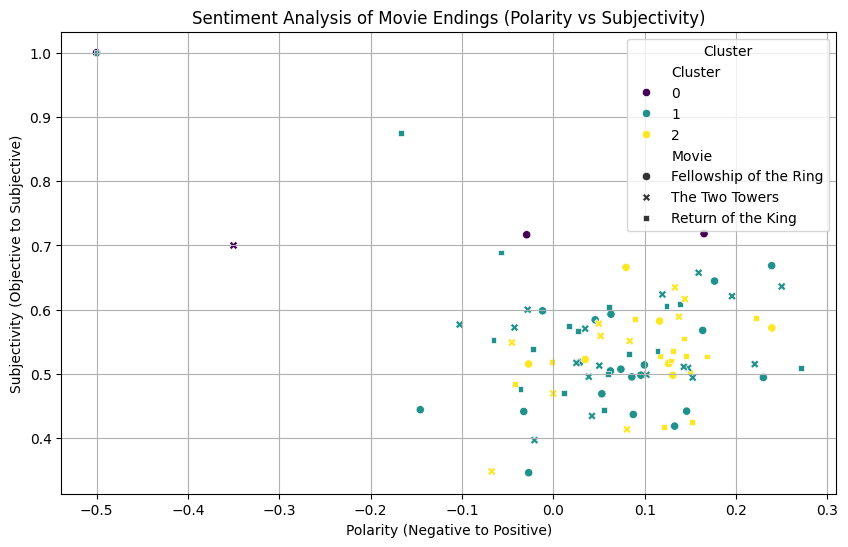

In [57]:
# Import necessary libraries
from textblob import TextBlob  # For sentiment analysis
import pandas as pd  # For data manipulation
import csv  # For reading and writing CSV files
from sklearn.cluster import KMeans  # For clustering
from tqdm import tqdm  # Progress bar for tracking
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For easier and more aesthetic plotting

# Function to analyze the sentiment of generated endings
def analyze_sentiment(ending):
    """
    Analyze the sentiment of the given text using TextBlob.
    Returns: Polarity (float) and Subjectivity (float).
    Polarity ranges from -1 (negative) to 1 (positive).
    Subjectivity ranges from 0 (objective) to 1 (subjective).
    """
    blob = TextBlob(ending)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Function to analyze movie endings and add sentiment analysis
def analyze_movie_endings_with_sentiment(csv_file, output_csv):
    """
    Reads the generated endings from the CSV file, analyzes sentiment,
    and writes the results to a new CSV file with sentiment information.
    """
    with open(csv_file, 'r', encoding='utf-8') as infile, open(output_csv, 'w', newline='', encoding='utf-8') as outfile:
        reader = csv.DictReader(infile)
        fieldnames = reader.fieldnames + ['Polarity', 'Subjectivity']  # Add sentiment columns
        writer = csv.DictWriter(outfile, fieldnames=fieldnames)

        writer.writeheader()
        for row in tqdm(reader, desc="Analyzing Sentiment", unit="ending"):
            # Analyze sentiment for each generated ending
            polarity, subjectivity = analyze_sentiment(row['Generated Ending'])
            row['Polarity'] = polarity
            row['Subjectivity'] = subjectivity
            writer.writerow(row)

# Function to annotate sentiment with model and cluster information and visualize the results
def annotate_and_visualize_sentiment(input_csv, reduced_embeddings, num_clusters=3):
    """
    Annotates the sentiment of movie endings with model and cluster information,
    performs clustering, and visualizes the results in scatter plots.
    """
    # Read the input CSV to load the data
    original_data = []
    with open(input_csv, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            original_data.append(row)
    
    # Extract movie titles (labels)
    labels = np.array([row['Movie'] for row in original_data])

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    movie_cluster_labels = kmeans.fit_predict(reduced_embeddings)

    # Create a dataframe to store results with cluster, model, and sentiment
    df = pd.DataFrame(original_data)
    df['Cluster'] = movie_cluster_labels

    # Add sentiment analysis to the dataframe
    df['Polarity'] = df['Generated Ending'].apply(lambda x: TextBlob(x).sentiment.polarity)
    df['Subjectivity'] = df['Generated Ending'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    # Display the full table (DataFrame) of results
    print("Full Table of Movie Endings with Sentiment and Clusters:")
    print(df)

    # Visualization: Scatter plot of polarity vs subjectivity, colored by cluster
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Polarity', y='Subjectivity', hue='Cluster', data=df, palette='viridis', style='Movie')
    plt.title('Sentiment Analysis of Movie Endings (Polarity vs Subjectivity)')
    plt.xlabel('Polarity (Negative to Positive)')
    plt.ylabel('Subjectivity (Objective to Subjective)')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

    # Return the dataframe for further analysis
    return df

# Main process to analyze sentiment, annotate with models and clusters, and visualize
def main():
    # Analyze movie endings and add sentiment to the CSV
    analyze_movie_endings_with_sentiment('lotr_endings.csv', 'lotr_endings_with_sentiment.csv')

    # Assuming 'reduced_embeddings' is already defined in your environment
    # Call the function to annotate sentiment, visualize with model and cluster info
    df_sentiment = annotate_and_visualize_sentiment('lotr_endings_with_sentiment.csv', reduced_embeddings)

# Call the main function to execute the workflow
main()